In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.optimize import fsolve

In [2]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, T_linha - T_curr)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T_linha = 27.4
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

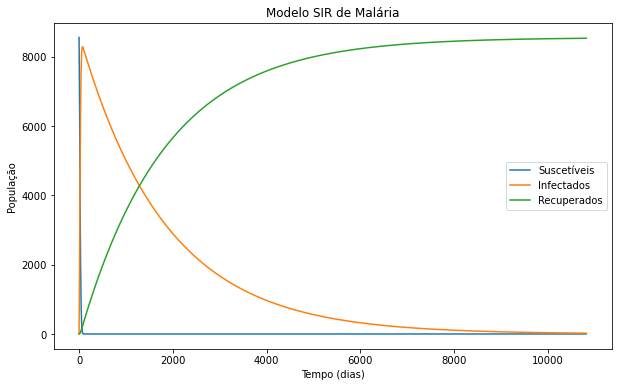

In [4]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [5]:
print(min(S_H))

-0.0006603180445592811


In [6]:
print(min(I_H))

0.0


In [7]:
print(max(S_H))

8558.0


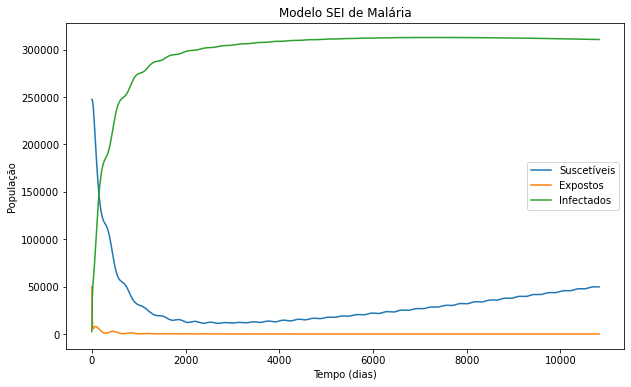

In [8]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [9]:
print(min(E_M))

1.177980802192352


$\mathcal{R}_0$ do SIR:

$$\Big | \dfrac{ab_2}{\gamma}\Big |$$

$\mathcal{R}_0$ do SEI:

$$\Big | \dfrac{ab_1b_3l}{b_3l\mu + \mu^2}\Big |$$

$\mathcal{R}_0$ do SIR/SEI:

$$\Big | \sqrt{\dfrac{a^2 b_1 b_2 b_3 l}{b_3\gamma l \mu + \gamma \mu^2}}\Big |$$

In [10]:
def model_R0(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, T_linha - T_curr)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]#, R0_sir_curr, R0_sei_curr, R0_curr]

In [11]:
def R0_sir(a, b2, gamma):
    return abs((a * b2) / gamma)
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, b1, b3, l, mu):
    return abs((a * b1 * b3 * l) / (b3 * l * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, b1, b2, b3, gamma, l, mu):
    return abs(((a** 2 * b1 * b2 * b3 * l) / (b3 * gamma * l * mu + gamma * mu** 2))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [12]:
def calculate_initial_values(R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b2, gamma):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T_linha - T0)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, b2, gamma)
    initial_R0_sei = R0_sei(a0, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, b1, b2, b30, gamma, l0, mu0)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full, a0

In [13]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b2, gamma)

In [14]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 13.807022583263038 
R0_sei = 563.0181601643467
R0_acoplado = 88.16804666190774
Taxa de picadas = 0.025218306088151666


In [15]:
x = 1/0.025218306088151666
x

39.65373393853089

Aproximadamente 1 picada por mosquito a cada 40 dias

### ------------------------------------------------------------------------------------------------------------------------------------------------------------

Para analisar os efeitos do desmatamento, queremos ver como alterar a biting rate $\Big(a(T) = \dfrac{T'-T(t)}{D_1}\Big)$ afeta o $R_0$. Para isso, podemos modificar $T'$ e $D_1$.

$T'$ original = 27.4 e $D_1$ original = 36.5

Aumentando $T'$:

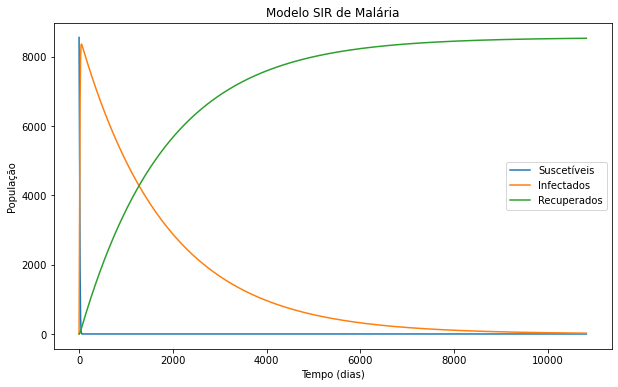

In [16]:
args = (28.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model_R0, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

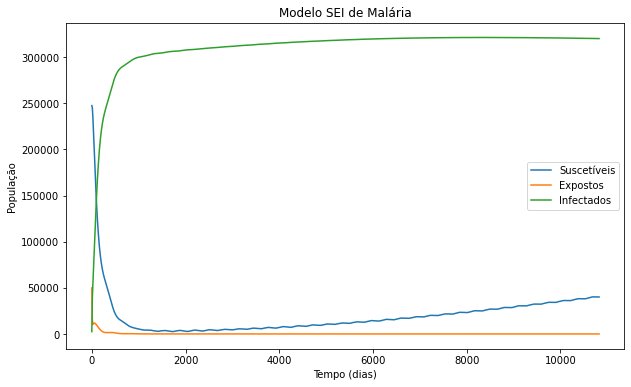

In [17]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [18]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 28.4, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b2, gamma)

In [19]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 28.80702258326304 
R0_sei = 1174.6831553895024
R0_acoplado = 183.9541360923534
Taxa de picadas = 0.05261556636212427


In [20]:
x = 1/0.05261556636212427
x

19.0057823024758

Aproximadamente 1 picada por mosquito a cada 20 dias

Aumentando a temperatura  limitante para a ocorrência de picadas em apenas $1^\circ C$, é possível ver que tanto os valores de $\mathcal{R}_0$ quanto a taxa de picadas foram mais que o dobro do que eram originalmente, tendo ocorrido um aumento de $108\%$ em relação ao valor original:

In [21]:
print(f'diff_R0_sir = {(28.80702258326304-13.807022583263038)/(13.807022583263038)*100}')
print(f'diff_R0_sei = {(1174.6831553895024-563.0181601643467)/(563.0181601643467)*100}')
print(f'diff_R0_acoplado = {(183.9541360923534-88.16804666190774)/(88.16804666190774)*100}')
print(f'diff_Taxa_de_picadas = {(0.05261556636212427-0.025218306088151666)/(0.025218306088151666)*100}')

diff_R0_sir = 108.64036695487917
diff_R0_sei = 108.6403669548792
diff_R0_acoplado = 108.64036695487917
diff_Taxa_de_picadas = 108.64036695487917


Aumentando $T'$ em $10\%$:

In [22]:
27.4+(27.4)*0.1

30.1400000000000

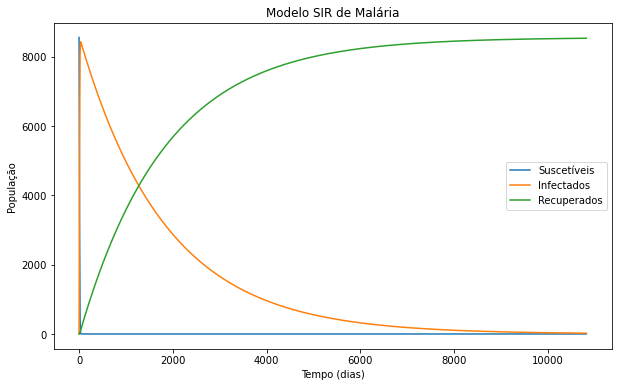

In [23]:
args = (30.14, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model_R0, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

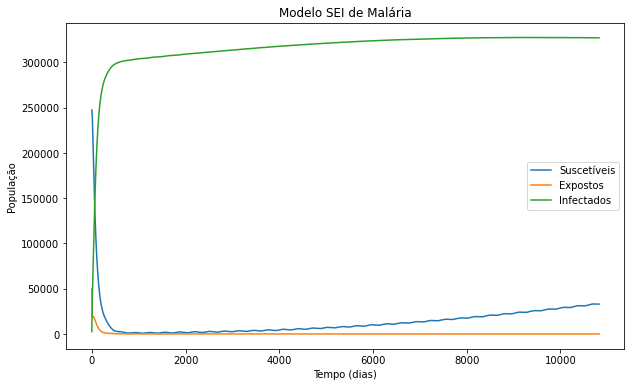

In [24]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [25]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 30.14, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b2, gamma)

In [26]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 54.90702258326307 
R0_sei = 2238.9802470812747
R0_acoplado = 350.62193170132906
Taxa de picadas = 0.10028679923883665


In [27]:
x = 1/0.10028679923883665
x

9.971402094691084

Aproximadamente 1 picada por mosquito a cada 10 dias

In [28]:
print(f'diff_R0_sir = {(54.90702258326307 -13.807022583263038)/(13.807022583263038)*100}')
print(f'diff_R0_sei = {(2238.9802470812747-563.0181601643467)/(563.0181601643467)*100}')
print(f'diff_R0_acoplado = {(350.62193170132906-88.16804666190774)/(88.16804666190774)*100}')
print(f'diff_Taxa_de_picadas = {(0.10028679923883665-0.025218306088151666)/(0.025218306088151666)*100}')

diff_R0_sir = 297.6746054563692
diff_R0_sei = 297.6746054563692
diff_R0_acoplado = 297.6746054563692
diff_Taxa_de_picadas = 297.6746054563692


Aumentando a temperatura  limitante para a ocorrência de picadas em $10\%$ do valor original, $\mathcal{R}_0$ e a taxa de picadas tiveram um aumento de quase $300\%$.

Diminuindo $T'$ em $10\%$:

In [29]:
27.4-(27.4)*0.1

24.6600000000000

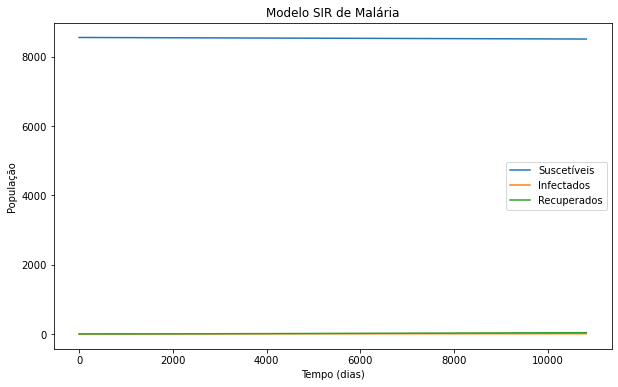

In [30]:
args = (24.66, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model_R0, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

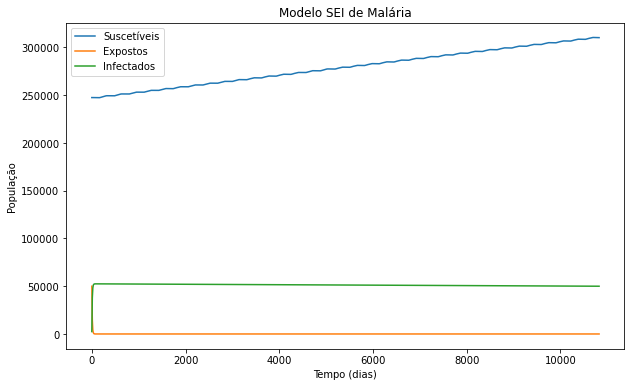

In [31]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [32]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 24.66, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b2, gamma)

In [33]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.000150000000000000 
R0_sei = 0.006116649952251557
R0_acoplado = 0.0009578608943044568
Taxa de picadas = 2.73972602739726e-7


In [34]:
x = 1/2.73972602739726e-7
x

3.65000000000000e6

Aproximadamente 1 picada por mosquito a cada 3650000 dias (10000 anos)

In [35]:
print(f'diff_R0_sir = {(0.000150000000000000 -13.807022583263038)/(13.807022583263038)*100}')
print(f'diff_R0_sei = {(0.006116649952251557-563.0181601643467)/(563.0181601643467)*100}')
print(f'diff_R0_acoplado = {(0.0009578608943044568-88.16804666190774)/(88.16804666190774)*100}')
print(f'diff_Taxa_de_picadas = {(2.73972602739726e-7-0.025218306088151666)/(0.025218306088151666)*100}')

diff_R0_sir = -99.99891359633045
diff_R0_sei = -99.99891359633045
diff_R0_acoplado = -99.99891359633045
diff_Taxa_de_picadas = -99.99891359633045


Diminuir a temperatura  limitante em $10\%$, por outro lado, fez com que $\mathcal{R}_0$ e a taxa de picadas caíssem para valores extremamente próximos de 0. Isso pode ser visualizado graficamente, com a população humana permanecendo inteiramente suscetível, já que uma taxa muito baixa de picadas fará com que haja pouca infecção, e consequentemente pouca recuperação.No caso dos mosquitos, a população de expostos irá rapidamente se extinguir já que $\dfrac{dE_m}{dt}$ estará dada em função principalmente da sua parte negatva, onde ocorre a saída de indivíduos devido à taxa de mortalidade e a passagem para o compartimento $I$. Por sua vez, $I$ terá um aumento imediato, devido à infecção dos mosquitos expostos no início do período, mas como não há entrada de mosquitos em $E$, a população de infectados também irá se "estabilizar", decaindo lentamente devido ao valor de $\mu$, também próximo de 0.

### ------------------------------------------------------------------------------------------------------------------------------------------------------------

Analisando o fator multiplicativo quando $T'$ aumenta em $10\%$:

In [36]:
def model_R0(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, T_linha - T_curr)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    T_linha_original = 27.4
    #print(a_curr)
    
    # a = (T' - T(t))/D1 ----> ak = (1.1T' - T(t))/D1 ----> 
    # ak = a + 0.1T'/D1 ----> a(k-1) = 0.1T'/D1 ----> 
    # k = ((0.1T'/D1)/a)+1
    
    print(f'k = {(1+((0.1*T_linha_original)/D1)/a0)}')
    print(f'ak = {a0*(1+((0.1*T_linha_original)/D1)/a0)}')
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [37]:
args = (30.14, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 100)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model_R0, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.00

k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.00

 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.

k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.00

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.00

 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.

 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.

 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.00

k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.00

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.

ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.075068

k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.000000000
ak = 0.0750687671232877
 
k = 274001.00

In [38]:
(30.14-27.4)/36.5

0.0750684931506850

In [39]:
a0

2.73972602739726e-7

In [40]:
(0.100286799238837 - 0.02521830608815167)/0.02521830608815167 * 100

297.674605456371